# Long Short Term Memory (LSTM) with Keras

We will use an LSTM to generate text character by character.

In [41]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras.models import load_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
# Internet traffic data (in bits) from a private ISP with centres in 11 European cities. 
# The data corresponds to a transatlantic link 
# and was collected from 06:57 hours on 7 June to 11:17 hours on 31 July 2005. 
# Hourly data. 

series = pd.read_csv('internet-traffic-data-in-bits-fr.csv', header = None, index_col=0, squeeze = True, 
                     parse_dates = True, dtype="float64")
print(len(series))
print(series.head())

1231
0
2005-06-07 07:00:00    5.671859e+10
2005-06-07 08:00:00    7.645616e+10
2005-06-07 09:00:00    8.253404e+10
2005-06-07 10:00:00    8.879700e+10
2005-06-07 11:00:00    9.024792e+10
Name: 1, dtype: float64


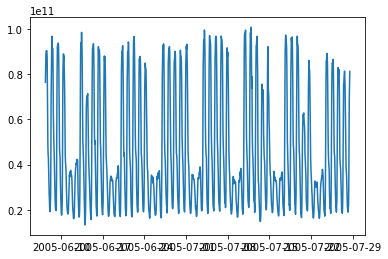

In [12]:
plt.plot(series)

We first split the data into training and test.

In [24]:
train_data = series.values[:800]
test_data = series.values[800:]
train_data[:10]

array([76456162968, 82534038485, 88796995092, 90247922345, 90146117117,
       90457410673, 89967660859, 87211742250, 73610634839, 56695326238])

We are going to preprocess the time series data as follows:

1) difference (use the successive differences for calculation)

2) scale to values between -1 and 1 (to match the LSTM's tanh activation)

In [32]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return(np.array(diff))

def inverse_difference(history, yhat, interval=1):
    # history[-len(series)] is first item, history[-len(series) - 1] is second, etc. 
    return yhat + history[-interval]

In [33]:
# differencing example 
toy_X = np.array([3, 4, 9, 7])
print(toy_X)
toy_X_diff = difference(toy_X)
print(toy_X_diff)
toy_X_inverse = inverse_difference(toy_X_diff, 3) ####################tbd!!

[3 4 9 7]
[ 1  5 -2]


In [34]:
train_diff = difference(train_data)
test_diff = difference(test_data)
train_diff[:10]

array([  6077875517,   6262956607,   1450927253,   -101805228,
          311293556,   -489749814,  -2755918609, -13601107411,
       -16915308601,  -8584724372])

In [37]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train_scaled = scaler.transform(train.reshape(-1,1))
    test_scaled = scaler.transform(test.reshape(-1,1))
    return scaler, train_scaled, test_scaled

def invert_scale(scaler, X, yhat):
    new_row = [x for x in X] + [yhat]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [38]:
scaler, train_scaled, test_scaled = scale(train_diff, test_diff)

/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/key/software/anaconda3/envs/tf3.5/lib/python3.5/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [2]:
num_epochs = 5

model_exists = False
model_name = "char_rnn_0.h5"

lstm_num_timesteps = 4 # for diffed series
effective_timesteps = lstm_num_timesteps+1
lstm_num_features = 1

num_neurons = 4
batchsize = 1
